In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

import urllib.request
import os
def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# Example -- Gaussian Process Regression with Large Datasets

We will be once again looking at the model for subcutaneous autoinjectors, replicating [Sree et. al. (2023)](https://doi.org/10.1016/j.jmbbm.2023.105695) to create a surrogate model. In this activity we will demonstrate when traditional or "Exact" Gaussian processes can fail, and introduce the concept of "Sparse" Gaussian processes as a solution.

Let's start by revisiting the exact Gaussian process regression model.

In [ ]:
pip install equinox gpjax==0.9.3

In [3]:
import jax
from jax import vmap, grad, jit
import jax.numpy as jnp
import jax.random as jrandom
from flax import nnx
import equinox as eqx
import optax
import pickle 
import pandas as pd
from typing import Optional
from jaxtyping import Float, Array
from jaxtyping import install_import_hook


jax.config.update("jax_enable_x64", True)
key = jrandom.PRNGKey(0);

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
    import gpjax.kernels as jk

In [4]:
class StandardScaler:
    """A transform that standarizes the data to have mean=0 and stdev=1.
    
    Parameters
    ----------
    data : Float[Array, "N d"]
        The data to be standarized. Shape is (N, d)=(number of samples, dimensionality).
    pretransform_forward : Optional[callable]
        An optional transformation to apply to the data before standarizing.
    pretransform_inverse : Optional[callable]
        The inverse of pretransform_forward.
    """
    def __init__(
        self, 
        data: Float[Array, "N d"], 
        pretransform_forward: Optional[callable] = None, 
        pretransform_inverse: Optional[callable] = None
    ):
        # Set up pre-transform functions
        if (pretransform_forward is None) ^ (pretransform_inverse is None):
            raise ValueError("Both pretransform_forward and pretransform_inverse must be provided.")
        elif pretransform_forward is None:
            pretransform_forward = lambda x: x
            pretransform_inverse = lambda x: x
        self.pre_forward = pretransform_forward
        self.pre_inverse = pretransform_inverse
        
        # Compute parameters for the standardizer
        pretransformed_data = vmap(self.pre_forward)(data)
        self.mean = jnp.mean(pretransformed_data, axis=0)
        self.std = jnp.std(pretransformed_data, axis=0)        
    
    def forward(self, x):
        return (self.pre_forward(x) - self.mean) / self.std
    
    def inverse(self, y):
        return self.pre_inverse(y * self.std + self.mean)

# Define new names for each input/output variable
old_input_names = ['mu', 'fill_volume', 'hGap0', 'lNeedle', 'dNeedle', 'FSpring0', 'kSpring', 'kappa5', 'kappa6', 'kappa7']
INPUT_NAMES = ['viscosity_cP', 'fill_volume_mL', 'air_gap_height_mm', 'needle_length_mm', 'needle_diameter_mm', 'spring_force_N', 'spring_constant_N_per_mm', 'kappa5', 'kappa6', 'kappa7']
old_output_names = ['Needle displacement (m)', 'Injection time (s)', 'max. acceleration (m/s^2)', 'max. deceleration (m/s^2)']
OUTPUT_NAMES = ['needle_displacement_m', 'injection_time_s', 'max_acceleration_m_per_s2', 'max_deceleration_m_per_s2']
column_name_mapper = dict(zip(old_input_names + old_output_names, INPUT_NAMES + OUTPUT_NAMES))

# Load the data
training_data_url = "https://github.com/PredictiveScienceLab/advanced-scientific-machine-learning/raw/refs/heads/main/book/data/autoinjector_surrogate/training_data.xlsx"
download(training_data_url, "training_data.xlsx")
train_data = pd.read_excel("training_data.xlsx", index_col=0).rename(columns=column_name_mapper).sample(frac=1).reset_index(drop=True)
test_data_url = "https://github.com/PredictiveScienceLab/advanced-scientific-machine-learning/raw/refs/heads/main/book/data/autoinjector_surrogate/training_data.xlsx"
download(test_data_url, "test_data.xlsx")
test_data = pd.read_excel("test_data.xlsx", index_col=0).rename(columns=column_name_mapper).sample(frac=1).reset_index(drop=True)

# Split data. Pass in column names to ensure correct order.
X_train = pd.DataFrame(train_data[INPUT_NAMES], columns=INPUT_NAMES)  
y_train = pd.DataFrame(train_data[OUTPUT_NAMES], columns=OUTPUT_NAMES)
X_test = pd.DataFrame(test_data[INPUT_NAMES], columns=INPUT_NAMES)
y_test = pd.DataFrame(test_data[OUTPUT_NAMES], columns=OUTPUT_NAMES)

input_transform = StandardScaler(X_train.values)

def partial_log_transform(x):
    return jnp.hstack([x[0], jnp.log(x[1]), jnp.log(x[2]), x[3]])

def partial_exp_transform(y):
    return jnp.array([y[0], jnp.exp(y[1]), jnp.exp(y[2]), y[3]])

output_transform = StandardScaler(y_train.values, pretransform_forward=partial_log_transform, pretransform_inverse=partial_exp_transform)

X_train_scaled = vmap(input_transform.forward)(X_train.values)
X_test_scaled = vmap(input_transform.forward)(X_test.values)
y_train_scaled = vmap(output_transform.forward)(y_train.values)
y_test_scaled = vmap(output_transform.forward)(y_test.values)

# place y_test_scaled into a dictionary with the output names as keys
y_test_scaled_dict = {o_name: y_test_scaled[:, i:i+1] for i, o_name in enumerate(OUTPUT_NAMES)}

# Zero mean
mean = gpx.mean_functions.Zero()

# Set the lengthscale/variance to decent values - they will be optimized later.
kernel = gpx.kernels.RBF(lengthscale=jnp.ones(X_train_scaled.shape[1]), variance=1.0)

# GP prior
prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)

likelihood = gpx.likelihoods.Gaussian(
    num_datapoints=y_train.shape[0],
    obs_stddev=0.001
)

posterior = prior * likelihood

# Loss function: negative marginal log likelihood
negative_mll = nnx.jit(lambda p, d: -gpx.objectives.conjugate_mll(p, d)) 

def optimize_gps(posterior, datasets, loss, num_iters=1000, batch_size=128, learning_rate=1e-2, verbose=True, *, key):
    """Optimizes the hyperparameters in the GP model (separately for each output)."""
    posteriors = {}
    loss_histories = {}
    
    # Do this in a loop to construct a GP for each output.
    for i, o_name in enumerate(OUTPUT_NAMES):
        key, subkey = jrandom.split(key)
        posteriors[o_name], loss_histories[o_name] = gpx.fit(
            model=posterior,
            objective=loss,
            train_data=datasets[o_name],
            optim=optax.adam(learning_rate),  # Adam optimizer
            num_iters=num_iters,
            batch_size=batch_size,
            key=subkey,
            verbose=False
        )

    return posteriors, loss_histories

def create_datasets(size=None, X=X_train_scaled, y=y_train_scaled, output_names=OUTPUT_NAMES):
    """Creates a GPJax datasets (one for each output) out of a subset of the training data."""
    if size is None:
        size = X.shape[0]
    datasets = {}
    for i, o_name in enumerate(output_names):
        datasets[o_name] = gpx.Dataset(X[:size], y[:size, i:i+1])
    return datasets

Okay, so let's notice what we're going to do differently this time. Instead of specifying the size of the dataset, we are going to train the GP on the entire available training set.

In [5]:
# Create a separate dataset for each output (and put it all in a single dictionary)
datasets = create_datasets(X_train_scaled.shape[0])

# Optimize the hyperparameters
key, subkey = jrandom.split(key)
posteriors, loss_histories = optimize_gps(posterior, datasets, negative_mll, key=subkey)

Okay, it seems to train without any problems. Let's evaluate it on a test point.

In [6]:
class Surrogate(eqx.Module):
    models: dict[str, gpx.gps.AbstractPosterior]
    train_data: dict[str, gpx.Dataset]
    input_transform: StandardScaler = input_transform
    output_transform: StandardScaler = output_transform
    IN_NAMES: list[str] = eqx.field(default_factory=lambda: INPUT_NAMES)
    OUT_NAMES: list[str] = eqx.field(default_factory=lambda: OUTPUT_NAMES)
    
    def __call__(self, X):
        """
        Evaluate the model at X.
        """
        Z = vmap(self.input_transform.forward)(X)
        y = self.get_scaled_predictive_mean_stdev(Z)[0]  # Just the mean
        return vmap(self.output_transform.inverse)(y)

    def sample(self, X, num_samples, *, key):
        """Sample the output. Contains both aleatoric and epistemic uncertainty."""
        Z = vmap(self.input_transform.forward)(X)
        y = self.sample_scaled_predictive(Z, num_samples, key=key)
        return vmap(self.output_transform.inverse)(y)
    
    def sample_scaled_predictive(self, X, num_samples, *, key):
        """Sample the scaled output. Contains both aleatoric and epistemic uncertainty."""
        predictive_dists = self._get_predictive_dists(X)
        y = []
        for o_name in self.OUT_NAMES:
            samples = predictive_dists[o_name].sample(seed=key, sample_shape=(num_samples,))
            y.append(samples)
        y = jnp.concatenate(y, axis=1)
        return y
    
    def sample_latent(self, X, num_samples, *, key):
        """Sample the latent space of the model (i.e., a GP sample before passing through the likelihood). Contains only epistemic uncertainty."""
        latent_dists = self._get_latent_dists(X)
        f = []
        for o_name in self.OUT_NAMES:
            samples = latent_dists[o_name].sample(seed=key, sample_shape=(num_samples,))
            f.append(samples)
        f = jnp.concatenate(f, axis=1)
        return f
    
    def get_scaled_predictive_mean_stdev(self, X):
        """Get the mean and standard deviation of the scaled output. Contains both aleatoric and epistemic uncertainty."""
        predictive_dists = self._get_predictive_dists(X)
        y_mean = []
        y_stdev = []
        for o_name in self.OUT_NAMES:
            y_mean.append(predictive_dists[o_name].mean())
            y_stdev.append(predictive_dists[o_name].stddev())
        return jnp.stack(y_mean, axis=1), jnp.stack(y_stdev, axis=1)
    
    def get_latent_mean_stdev(self, X):
        """Get the mean and standard deviation of the latent distribution. Contains only epistemic uncertainty."""
        latent_dists = self._get_latent_dists(X)
        f_mean = []
        f_stdev = []
        for o_name in self.OUT_NAMES:
            f_mean.append(latent_dists[o_name].mean())
            f_stdev.append(latent_dists[o_name].stddev())
        return jnp.stack(f_mean, axis=1), jnp.stack(f_stdev, axis=1)
    
    def _get_latent_dists(self, X):
        latent_dists = {}
        for o_name in self.OUT_NAMES:
            latent_dists[o_name] = self.models[o_name].predict(X, self.train_data[o_name])
        return latent_dists
    
    def _get_predictive_dists(self, X):
        latent_dists = self._get_latent_dists(X)
        predictive_dists = {}
        for o_name in self.OUT_NAMES:
            predictive_dists[o_name] = self.models[o_name].likelihood(latent_dists[o_name])
        return predictive_dists

In [7]:
# surrogate_ = Surrogate(
#     models=posteriors,
#     train_data=datasets,
#     input_transform=input_transform,
#     output_transform=output_transform
# )

# # Select a random test point
# x = X_test.values[0:1]
# x_scaled = input_transform.forward(x)

# # Get the mean and standard deviation of the scaled output
# y_scaled_mean, y_scaled_stdev = surrogate_.get_scaled_predictive_mean_stdev(x_scaled)

# print('The scaled predictions are:')
# for i, o_name in enumerate(OUTPUT_NAMES):
#     print(f"\t{o_name:<25}:  {y_scaled_mean[0, i]:.2f} +/- {y_scaled_stdev[0, i]:.2f}")

What happened? It was working fine in the last activity. Why does the kernel crash now? Recall that when we perform inference with Gaussian processes, we need to invert the covariance matrix. This inversion is an $O(n^3)$ operation, where $n$ is the number of training points. This is why we were able to train the GP on a small subset in the last activity, but the kernel crashed when we tried to train it on the entire dataset.

How can we mitiage this inability to perform Gaussian process regression on large datasets? 

One solution is to use Sparse Gaussian Process Regression. The idea is to approximate the covariance matrix of the data with a smaller covariance matrix of pseudo-points. This allows us to approximate the true posterior and perform inference without inverting the matrix formed by the actual training data. 

**Before you continue, either comment out the last cell or delete it. Then restart the kernel and rerun the above cells and let's continue.**

Let's initialize our pseudo-points, commonly called inducing points by bounding them on by the minimum and maximum of the scaled inputs. The number of inducing points is a hyperparameter that we can tune. We will set it to 100 for now.

In [8]:
num_inducing_pts = 100

# Print the minimum and maximum values of the input data
min_vals = jnp.min(X_train_scaled, axis=0)
max_vals = jnp.max(X_train_scaled, axis=0)

# Create inducing points for each feature
inducing_pts = jnp.array([
    jnp.linspace(min_vals[i], max_vals[i], num_inducing_pts)
    for i in range(X_train_scaled.shape[1])
]).T

print(inducing_pts.shape)

(100, 10)


The prior and the likelihood are the same as the exact Gaussian process.

In [9]:
# Zero mean
mean = gpx.mean_functions.Zero()

# Set the lengthscale/variance to decent values - they will be optimized later.
kernel = gpx.kernels.RBF(lengthscale=jnp.ones(X_train_scaled.shape[1]), variance=1.0)

# GP prior
prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)

likelihood = gpx.likelihoods.Gaussian(
    num_datapoints=y_train_scaled.shape[0],
    obs_stddev=0.001
)

Here is the approximate posterior distribution, notice how you input the posterior that we used before as well as the inducing points.

In [10]:
# Exact GP posterior
posterior = prior * likelihood

# Approximate posterior
q = gpx.variational_families.VariationalGaussian(posterior=posterior, 
                                                 inducing_inputs=inducing_pts)

Instead of the marginal log-likelihood, we need a variational loss function. Here we will be maximizing the ELBO. Recall the ELBO stands for the evidence lower bound and is analogous to minizing the KL divergence between the approximate posterior that we constructed and the true posterior. What this means is that the inducing points will be optimized to approximate the true posterior as closely as possible.

In [11]:
elbo = lambda p, d: -gpx.objectives.elbo(p, d)

Approximate GPs are a bit more expensive to train, so for the purposes of this demonstration, we will only train it on one of our output parameters. Feel free to change to a different output parameter key to see how the model performs.

In [12]:
# Create a separate dataset for each output (and put it all in a single dictionary)
print(datasets)

output = 'needle_displacement_m'

sparse_dataset = datasets[output]

{'needle_displacement_m': Dataset(Number of observations: 10000 - Input dimension: 10), 'injection_time_s': Dataset(Number of observations: 10000 - Input dimension: 10), 'max_acceleration_m_per_s2': Dataset(Number of observations: 10000 - Input dimension: 10), 'max_deceleration_m_per_s2': Dataset(Number of observations: 10000 - Input dimension: 10)}


Let's train the model. If you have access to a GPU, this will be much faster.

Feel free to play around with the training hyperparameters. If the value on the training bar shows NaN, try reducing the learning rate or increasing the batch size.

In [14]:
# Create a function for training one sparse GP
sparse_posterior, sparse_loss = gpx.fit(
            model=q,
            objective=elbo,
            train_data=sparse_dataset,
            optim=optax.adam(0.001),  # Adam optimizer
            num_iters=50000,
            batch_size=32,
            key=subkey,
            verbose=False
        )

Okay, that wasn't too bad. Let's take a look at the evolution of the ELBO over the iterations. Log-scale is helpful here because the ELBO can be quite large.

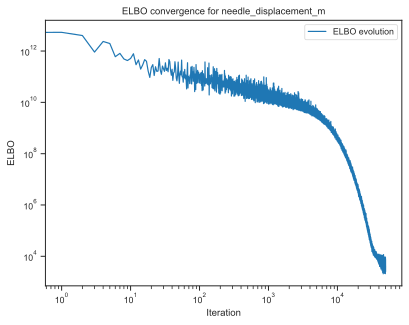

In [15]:
fig, ax = plt.subplots()
ax.plot(sparse_loss, label="ELBO evolution")
ax.set_xlabel("Iteration")
ax.set_ylabel("ELBO")
ax.set_title(f"ELBO convergence for {output}")
plt.xscale("log")
plt.yscale("log")
ax.legend()
plt.show()

It seems to converge nicely, lets predict on our test points.

In [16]:
latent_dist = sparse_posterior(X_test_scaled)
predictive_dist = sparse_posterior.posterior.likelihood(latent_dist)
scaled_mean = predictive_dist.mean()
scaled_sigma = predictive_dist.stddev()

Great, we performed inference on the test point without any issues. Again, why is this? Because we are only inverting the covariance matrix of the inducing points, which is much smaller than the covariance matrix of the actual training data. This results in a inference cost of $O(bm^2 + m^3)$, where $m$ is the number of inducing points and $b$ is the min-batch size. This is much more computationally efficient than the $O(n^3)$ cost of exact Gaussian processes.

The model should perform better as we increase the number of inducing points, but it will also be more computationally expensive to perform inference. These are all trade-offs that you will need to consider when using sparse Gaussian processes.

Let's visualize our predictions and see how we did.

(10000,)


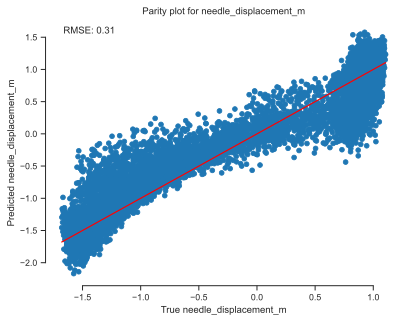

In [17]:
# Access the scaled measured value
measured_data = y_test_scaled_dict[output].squeeze()

print(measured_data.shape)

# Compute RMSE
rmse = jnp.sqrt(jnp.mean((scaled_mean - measured_data)**2))

# Create parity plot
fig, ax = plt.subplots()
ax.scatter(measured_data, scaled_mean)
ax.plot(measured_data, measured_data, 'r')
# ax.errorbar(measured_data, scaled_mean, yerr=scaled_sigma, fmt='o')
ax.annotate(f"RMSE: {rmse:.2f}", (0.05, 0.95), xycoords='axes fraction')
ax.set_xlabel(f"True {output}")
ax.set_ylabel(f"Predicted {output}")
ax.set_title(f"Parity plot for {output}")
sns.despine(trim=True)
plt.show()


We can perform all the same diagnostics with the approximate GP as we did with the exact GP from the previous activity.

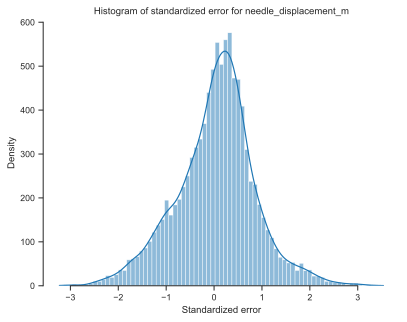

In [18]:
standardized_error = (scaled_mean - measured_data) / scaled_sigma

# plot a histogram of the standardized error
fig, ax = plt.subplots()
sns.histplot(standardized_error, kde=True, ax=ax)
ax.set_xlabel("Standardized error")
ax.set_ylabel("Density")
ax.set_title(f"Histogram of standardized error for {output}")
sns.despine(trim=True)
plt.show()

For extra practice go through and make the same plots as we did in the previous activity. See how the approximate GP results compare to the exact GP results.

# Questions:

- Is training the approximate GP on the entire dataset worth the computational cost? What are the trade-offs?

- Can you think of any large datasets that you have worked with in the past that could benefit from using an approximate GP?